In [3]:
###############
# Need plotting functionality for complex Delta
# Scale invariance in conumbering space?
# Calculate supercurrent
###############
# Add get_para_current to simple_ring
# Add thetas to tight-binding model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import kwant

import tinyarray

import lmfit as lmf

import scipy.linalg as lin

from tqdm import tqdm
import pickle

from scipy import stats

import warnings

In [5]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 6,3.6
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams.update({'figure.autolayout': True})

In [6]:
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])
tau_0 = tinyarray.array([[1, 0], [0, 1]])

def Lorentzian(eex, ee, gam):
    return (gam/np.pi)*(1/((eex-ee)**2 + gam**2))

def Fermi(eps, beta = 'inf'):
    if beta == 'inf':
        return int(eps<0)
    else:
        return 1/(1+np.exp(beta*eps))
    
Fibonacci_number = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657]
tau_approximant = [1, 2.0, 1.5, 1.6666666666666667, 1.6, 1.625, 1.6153846153846154, 1.619047619047619, 1.6176470588235294, 1.6181818181818182, 1.6179775280898876, 1.6180555555555556, 1.6180257510729614, 1.6180371352785146, 1.618032786885246, 1.618034447821682, 1.6180338134001253, 1.618034055727554, 1.6180339631667064, 1.6180339985218033, 1.618033985017358, 1.6180339901755971]

In [7]:
class Fibonacci_chains:
    def __init__(self):
        self.Fibonacci_cellar = {}
    
    def get_chain(self,n,j):
        N = Fibonacci_number[n]
        if j>=N:
            warnings.warn("phi greater than 2 pi. Using modulo 2 pi.")
            j = j%N
        try:
            chain = self.Fibonacci_cellar[(n,j)]
        except KeyError:

            tau = tau_approximant[n]
            phi = 2*np.pi*j/N
            chain = ["A" if np.sign(np.cos(2*np.pi*m*(1/tau) + phi) - np.cos(np.pi*(1/tau)))>=0 else "B" for m in range(N)]
            self.Fibonacci_cellar[(n,j)] = chain
        return chain

FCs = Fibonacci_chains()

In [8]:
class TBmodel:
    def __init__(self, LL, ts, us, vs):
        self.LL = LL
        self.a = 1
        self.ts, self.us, self.vs = ts, us, vs
        self.Delta = np.array([1]*self.LL)
        self.Pot = np.zeros(self.LL)

    def onsite(self, site, Delta, Pot):
        (x,y) = site.tag
        return (self.us[x]+Pot[x])*tau_z - self.vs[x]*Delta[x]*tau_x
    
    def hopping(self,site1,site2):
        (x2,y2) = site2.tag
        (x1,y1) = site1.tag
        return self.ts[x1]*tau_z*np.exp(1j*self.thetas[x1])
    
    def make_syst(self):
        self.syst = kwant.Builder()
        self.lat = kwant.lattice.square(self.a, norbs = 2)
        
        self.syst[(self.lat(x,0) for x in range(self.LL))] = self.onsite
        self.syst[((self.lat(x+1,0),self.lat(x,0)) for x in range(self.LL-1))] = self.hopping
        self.syst[((self.lat(0,0), self.lat(self.LL-1,0)))] = self.hopping
        
        self.fsyst = self.syst.finalized()
        return

    def solve(self,H):
        (evals, evecs) = lin.eigh(H)
    
        uvecs = evecs[::2]
        vvecs = evecs[1::2]
        
        return (evals[self.LL:],uvecs[:,self.LL:],vvecs[:,self.LL:])

    def iterate(self):
        def self_cons(H):
            (evals, uvecs, vvecs) = self.solve(H)
            self.evals, self.uvecs, self.vvecs = (evals, uvecs, vvecs)
            
            Delta = np.zeros(self.LL, dtype = "complex128")
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                Delta += (1-2*Fermi(ee, beta = self.beta))*uvec*vvec.conjugate()
            
            occupancy = np.zeros(self.LL)
            for ee, uvec, vvec in zip(evals, uvecs.T, vvecs.T):
                    occupancy += Fermi(ee, beta = self.beta)*2*np.abs(vvec)**2 + (1-Fermi(ee))*2*np.abs(uvec)**2
            
            Pot = 1/2*self.vs*occupancy
            Pot = Pot + 0.0001*np.ones(len(Pot))

            return (Delta, Pot)
        
        err_Delta = np.ones(1)
        cc = 0
        
        while any([Del>10**(-10) and err/Del>0.001 for err,Del in zip(err_Delta, self.Delta)]):
            H = self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
            newDelta, newPot = self_cons(H)
            err_Delta = np.abs(newDelta - self.Delta)
            
            cc += 1    
            self.Delta, self.Pot = newDelta, newPot
        
        print("Convergence took {} iterations".format(cc))
        
        self.H = H
        return self.Delta, self.Pot
        
    
    def get_DOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros(eex.shape)
        DOSv = np.zeros(eex.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += np.linalg.norm(uvec)**2*Lorentzian(eex,ee,gam) 
                DOSv += np.linalg.norm(vvec)**2*Lorentzian(eex,-ee,gam)
                
        self.DOS = (DOSu + DOSv)/self.LL
        return  self.DOS , eex
    
    def get_LDOS(self, gam = None, Num_es = 1000):
        emax = np.max(np.abs(self.evals))
        
        if gam == None:
            gam = 2*emax/self.LL
            
        eex = np.linspace(-1.2*emax,1.2*emax, Num_es)
        DOSu = np.zeros((self.uvecs.shape[0],eex.shape[0]))
        DOSv = np.zeros(DOSu.shape)
        
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            if ee>0:
                DOSu += (np.abs(uvec)**2)[:,np.newaxis]*Lorentzian(eex,ee,gam)
                DOSv += (np.abs(vvec)**2)[:,np.newaxis]*Lorentzian(eex,-ee,gam)      
            
        self.LDOS = (DOSu + DOSv)/self.LL
        return  self.LDOS,eex
    
    def get_ham(self,inds):
        if inds == 'full':
            return self.fsyst.hamiltonian_submatrix(params = dict(Delta = self.Delta, Pot = self.Pot))
        else:
            return self.fsyst.hamiltonian(*inds, params = dict(Delta = self.Delta, Pot = self.Pot))
        
        
        

In [9]:
class simple_ring(TBmodel):
    """
    Wrapper around TBmodel. Will generate a 1D tight-binding model with the parameters provided by chain.
    beta is the inverse temperature. use beta = "inf" for 0T.
    """
    def __init__(self, chain, beta = "inf"):
        self.chain = chain
        self.NN = chain["N"]
        self.beta = beta
        self.thetas = np.zeros(self.NN)

        
        ts = np.array(chain["t"])
        us = np.array(chain["u"])
        vs = np.array(chain["v"])
        
        TBmodel.__init__(self, self.NN, ts, us, vs)

        self.make_syst()
        
    def add_hopping_phases(self, ls, A):
        self.ls = np.array(ls)
        self.A = A
        self.thetas = self.ls*self.A
        
    def add_hopping_phases2(self, ls, A):
        self.ls = np.array(ls)
        self.A = A
        self.thetas = np.zeros(len(self.ls))
        self.thetas[-1] = self.A*np.sum(self.ls)
        
    def get_current_para(self):
        current_para = np.zeros(self.LL, dtype = "complex128")
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            current_para += -1/(2*self.NN)*self.ls*2*np.imag(self.ts*np.exp(1j*self.thetas)*(
                Fermi(ee, beta = self.beta)*uvec*(np.roll(uvec,-1).conjugate() )
                + (1-Fermi(ee, beta = self.beta))*(vvec*np.roll(vvec,-1).conjugate())
            )     )            
        self.current_para = current_para
        return current_para
    
    def get_current_dia(self):
        current_dia = np.zeros(self.LL, dtype = "complex128")
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            current_dia += 1/(2*self.NN)*self.A*self.ls**2*2*np.real(self.ts*np.exp(1j*self.thetas)*(
                Fermi(ee, beta = self.beta)*uvec*(np.roll(uvec,-1).conjugate() )
                + (1-Fermi(ee, beta = self.beta))*(vvec*np.roll(vvec,-1).conjugate())
                                   ))            
        self.current_dia = current_dia
        return current_dia
    
    def get_current_para2(self):
        Paramagnetic_current_contributions = [];
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            u_term = uvec.conjugate()*np.roll(uvec,-1)*Fermi(ee, beta = self.beta)
            v_term = vvec*np.roll(vvec.conjugate(),-1)*(1-Fermi(ee, beta = self.beta))
            Paramagnetic_current_contributions.append(
            (1/(2*self.NN))*2*self.ls*self.ts*np.imag(np.exp(1j*self.thetas)*(u_term + v_term))
            )
        return np.array(Paramagnetic_current_contributions)
    
    def get_current_dia2(self):
        Diamagnetic_current_contributions = [];
        for ee, uvec, vvec in zip(self.evals, self.uvecs.T, self.vvecs.T):
            u_term = uvec.conjugate()*np.roll(uvec,-1)*Fermi(ee, beta = self.beta)
            v_term = vvec*np.roll(vvec.conjugate(),-1)*(1-Fermi(ee, beta = self.beta))
            Diamagnetic_current_contributions.append(
            (1/(2*self.NN))*2*self.A*(self.ls**2)*self.ts*np.real(np.exp(1j*self.thetas)*(u_term + v_term))
            )
        return np.array(Diamagnetic_current_contributions)
            
        

In [10]:
def chainFC(n = 3, t=-1, w = 0.1, phi = 0, u = 0, v = 0, wu = 0, wv = 0, PBC = True, phase = 0):
    """
    Generates the hoppings, the on-site potentials, and the BCS attraction terms for a chain of length Fibonacci_number[n]
    The ts modulate according to the Fibonacci word with tA-tB = w and phi = phi. On-site potential and BCS attraction 
    is drawn from the uniform distribution u±wu and v±wv respectively. PBC = True will use periodic boundary conditions, 
    while PBC=False will use open boundary conditions.
    """
    L = Fibonacci_number[n]
    tau = tau_approximant[n]
    FC = FCs.get_chain(n,phi)
    
    wa = 2*w/(1+tau)
    wb = tau*wa

    ts = [1-wa if letter =="A" else 1+wb for letter in FC]
    ts[-1] = ts[-1]*np.exp(1j*phase)
    
    if PBC:
        chain = {
            "N": L,
            "t": -np.array(ts),
            "u" : u - wu/2 + wu*np.random.rand(L),
            "v" : v - wv/2 + wv*np.random.rand(L)
        }
        
    else:
        chain = {
            "N": L+1,
            "t": -np.concatenate((np.zeros(1),np.array(ts))),
            "u" : u - wu/2 + wu*np.random.rand(L+1),
            "v" : v - wv/2 + wv*np.random.rand(L+1)
        }
        
    return chain

In [11]:
def get_staircase(seq):
    walker = np.array([0,0])
    staircase = [np.array([0,0])]
    for letter in seq:
        if letter == "A":
            step = walker + np.array([1,0])
        else:
            step = walker + np.array([0,1])
        staircase.append(step)
        walker = step
    return staircase

def get_ordering(n, phi):
    seq = FCs.get_chain(n,phi)
    staircase = get_staircase(seq)
    alpha = np.arctan(1/tau_approximant[n-1])
    perp = np.array([-np.sin(alpha),np.cos(alpha)])
    perpendicular_components = [np.dot(perp,step) for step in staircase]
    ordering = np.argsort(perpendicular_components)
    ordering = np.hstack((ordering[Fibonacci_number[n-2]:],ordering[:Fibonacci_number[n-2]]))
    return np.mod(ordering, Fibonacci_number[n])

In [12]:
class Fibonacci_sequence:
    def __init__(self, n, phi):
        self.sequence = FCs.get_chain(n, phi)
        self.n = n
        self.phi = phi
        
    def get_staircase(self):
        seq = self.sequence
        walker = np.array([0,0])
        staircase = [np.array([0,0])]
        for letter in seq:
            if letter == "A":
                step = walker + np.array([1,0])
            else:
                step = walker + np.array([0,1])
            staircase.append(step)
            walker = step
        return staircase
    
    def get_ordering(self):
        staircase = self.get_staircase()
        alpha = np.arctan(1/tau_approximant[self.n-1])
        perp = np.array([-np.sin(alpha),np.cos(alpha)])
        perpendicular_components = [np.dot(perp,step) for step in staircase]
        ordering = np.argsort(perpendicular_components)
        ordering = np.hstack((ordering[Fibonacci_number[self.n-2]:],ordering[:Fibonacci_number[self.n-2]]))
        self.perp_ordering = np.mod(ordering, Fibonacci_number[self.n])
        return self.perp_ordering
        
  

## Currents Test

In [13]:
n = 11
phi = 0
v = -1.5
chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)

In [14]:
Model = simple_ring(chain, beta = 20)
ls = np.ones(Model.NN)

In [15]:
A = np.pi/(Model.NN)
Model.add_hopping_phases(ls, A)
Model.iterate();

Convergence took 37 iterations


## real checks

In [16]:
Ts = np.linspace(0, 0.12, 21)
betas = ['inf'] + list(1/Ts[1:])

In [17]:
n = 11
phi = 0
v = -1.5
Models = []
for beta in betas:
    chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)
    Model = simple_ring(chain, beta = beta)
    
    ls = np.ones(Model.NN)
    A = ((0*2 + 1)*np.pi)/(Model.NN)
    Model.add_hopping_phases2(ls, A)
    
    Model.iterate()
    Models.append(Model)

Convergence took 23 iterations
Convergence took 23 iterations
Convergence took 23 iterations
Convergence took 23 iterations
Convergence took 24 iterations
Convergence took 25 iterations
Convergence took 27 iterations
Convergence took 30 iterations
Convergence took 35 iterations
Convergence took 43 iterations
Convergence took 61 iterations
Convergence took 129 iterations
Convergence took 776 iterations
Convergence took 491 iterations
Convergence took 360 iterations
Convergence took 286 iterations
Convergence took 239 iterations
Convergence took 206 iterations
Convergence took 182 iterations
Convergence took 164 iterations
Convergence took 149 iterations


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'A = 0.01, Total phase = 1.0$\\pi$, effective phase = 1.0$\\pi$')

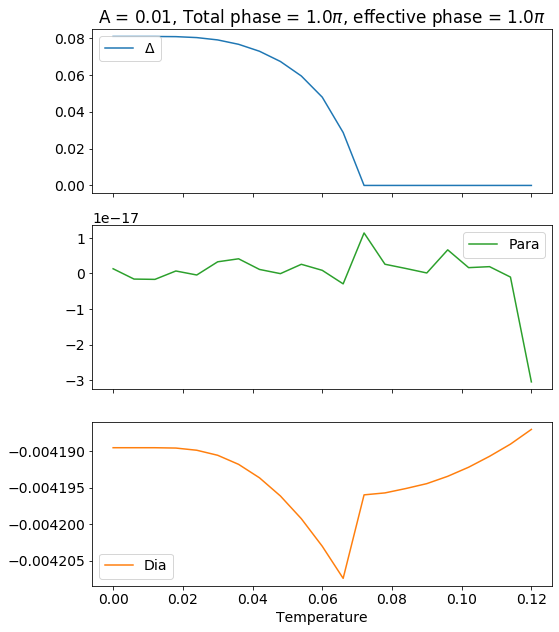

In [18]:
fig, axes = plt.subplots(3, sharex = True, figsize = (8,9))
ax1, ax2, ax3 = axes
ax1.plot(Ts, [np.average(Model.Delta) for Model in Models],"C0", label = "$\\Delta$")

ax2.plot(Ts, [np.sum(Model.get_current_para2())for Model in Models],"C2", label ="Para")

ax3.plot(Ts, [np.sum(Model.get_current_dia2())for Model in Models], "C1", label = "Dia")

ax1.legend(loc = "upper left")
ax2.legend()
ax3.legend()

ax3.set_xlabel("Temperature")

totalPhase = (Model.NN*A)

ax1.set_title("A = {:.2f}, Total phase = {:.1f}$\\pi$, effective phase = {:.1f}$\\pi$".format(A, totalPhase/np.pi, (totalPhase%(2*np.pi))/np.pi))

# plt.savefig("temp2pi.png")

## diamagnetic current

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.004270410355529913+0j)


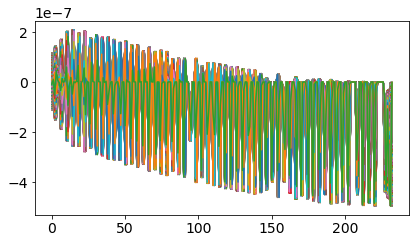

In [260]:
j_d = Model.get_current_dia2()
plt.plot(j_d)
print(np.sum(j_d))

### as a function of temperature

In [177]:
n = 11
phi = 0
v = -1.5
chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0,PBC = True, phase = 0)

Convergence took 23 iterations
Convergence took 23 iterations
Convergence took 23 iterations
Convergence took 23 iterations
Convergence took 24 iterations
Convergence took 25 iterations
Convergence took 26 iterations
Convergence took 28 iterations
Convergence took 32 iterations
Convergence took 37 iterations
Convergence took 45 iterations
Convergence took 61 iterations
Convergence took 107 iterations


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


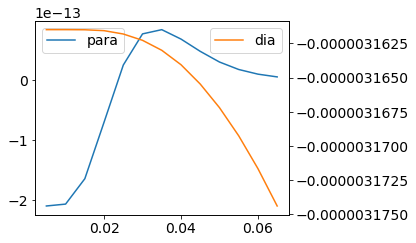

In [178]:
A = 0
Ts = np.arange(0.005, 0.07, 0.005)
betas = 1/Ts
jps = []
jds = []
for beta in betas:
    Model = simple_ring(chain, beta = beta)
    ls = np.ones(Model.NN)
    Model.add_hopping_phases(ls, A)
    Model.iterate()
    j_p = np.sum(Model.get_current_para())
    j_d = np.sum(Model.get_current_dia())
    jps.append(j_p)
    jds.append(j_d)
   
fig, ax = plt.subplots()

ax.plot(Ts, jps, "C0", label = "para")
ax1 = ax.twinx()
ax1.plot(Ts, jds, "C1", label = "dia")

ax.legend(loc  = "upper left")
ax1.legend(loc = "upper right")

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Temperature (T_c ~ 0.08)')

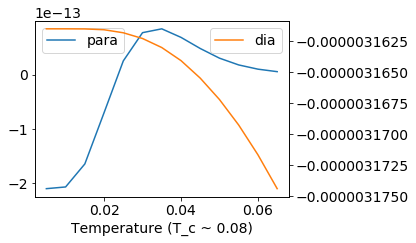

In [179]:
fig, ax = plt.subplots()

ax.plot(Ts, jps, "C0", label = "para")
ax1 = ax.twinx()
ax1.plot(Ts, jds, "C1", label = "dia")

ax.legend(loc  = "upper left")
ax1.legend(loc = "upper right")
ax.set_xlabel("Temperature (T_c ~ 0.08)")

## Order parameter $\Delta$

In [19]:
n = 12
phi = 0
v = -1.5
chain = chainFC(n = n, phi = phi,v = v, u = -v/2, w = 0.1,PBC = True, phase = 0)

In [20]:
Model = simple_ring(chain, beta = "inf")

In [21]:
Model.iterate()

Convergence took 21 iterations


(array([0.08451299+0.j, 0.07053898+0.j, 0.11735545+0.j, 0.07796381+0.j,
        0.08065784+0.j, 0.11294559+0.j, 0.07468609+0.j, 0.08232301+0.j,
        0.09378287+0.j, 0.06988254+0.j, 0.13475061+0.j, 0.07029272+0.j,
        0.09379265+0.j, 0.08361667+0.j, 0.07476975+0.j, 0.11555665+0.j,
        0.08011036+0.j, 0.08010574+0.j, 0.11556476+0.j, 0.07476391+0.j,
        0.08362121+0.j, 0.09378072+0.j, 0.07029473+0.j, 0.13473023+0.j,
        0.06989087+0.j, 0.09377057+0.j, 0.08234719+0.j, 0.07468066+0.j,
        0.11299251+0.j, 0.08064429+0.j, 0.07799893+0.j, 0.11732061+0.j,
        0.07059993+0.j, 0.08449575+0.j, 0.08463904+0.j, 0.07053956+0.j,
        0.11757692+0.j, 0.07791874+0.j, 0.08081436+0.j, 0.11279482+0.j,
        0.0749352 +0.j, 0.08222238+0.j, 0.09428219+0.j, 0.06980729+0.j,
        0.13560232+0.j, 0.06980731+0.j, 0.09428219+0.j, 0.08222244+0.j,
        0.0749352 +0.j, 0.11279495+0.j, 0.08081434+0.j, 0.07791884+0.j,
        0.11757686+0.j, 0.07053972+0.j, 0.08463902+0.j, 0.084496

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


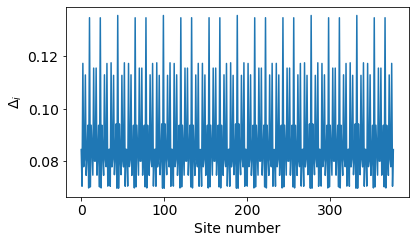

In [294]:
fig, ax = plt.subplots()

ax.plot(Model.Delta)
ax.set_xlabel("Site number")
ax.set_ylabel("$\\Delta_i$")

plt.savefig("Delta_temp_FC_12.png")

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$\\Delta$')

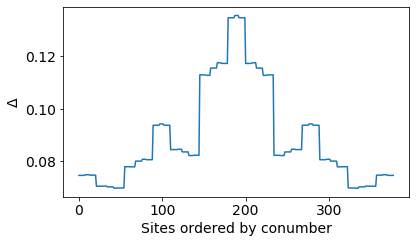

In [295]:
fig, ax = plt.subplots()

seq = Fibonacci_sequence(n, phi)
ax.plot(Model.Delta[seq.get_ordering()])
ax.set_xlabel("Sites ordered by conumber")
ax.set_ylabel("$\\Delta$")

## DOS

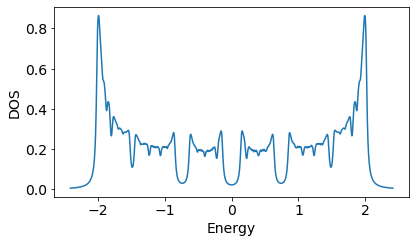

In [26]:
DOS, eex = Model.get_DOS(gam = 0.02)

fig, ax = plt.subplots()

ax.plot(eex, DOS)
ax.set_xlabel("Energy")
ax.set_ylabel("DOS")

plt.savefig("DOS_temp_FC.png")

Convergence took 3 iterations


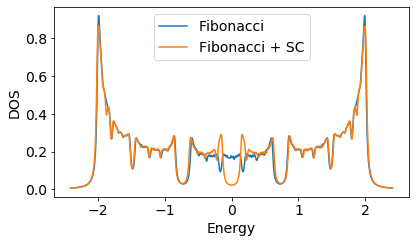

In [28]:
chain = chainFC(n = n, phi = phi, v = 0, u = 0, w = 0.1, PBC = True, phase = 0)
Model2 = simple_ring(chain)
Model2.iterate()
DOS2, eex2 = Model2.get_DOS(gam = 0.02)

fig, ax = plt.subplots()

ax.plot(eex2, DOS2, label = "Fibonacci")
ax.plot(eex, DOS, label = "Fibonacci + SC")
ax.set_xlabel("Energy")
ax.set_ylabel("DOS")
ax.legend()

plt.savefig("DOS_temp_FC.png")

## Get E as a function of phase

In [31]:
phases = np.linspace(-np.pi,np.pi,50)
ev_list = []
for phase in phases:
    chain = chainFC(n = 12, v = -1.5, u = 0.75, w = 0.1,PBC = True, phase = phase)
    Model = simple_ring(chain)
    Model.iterate()
    ev_list.append(Model.evals)
    

Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Convergence took 21 iterations
Converge

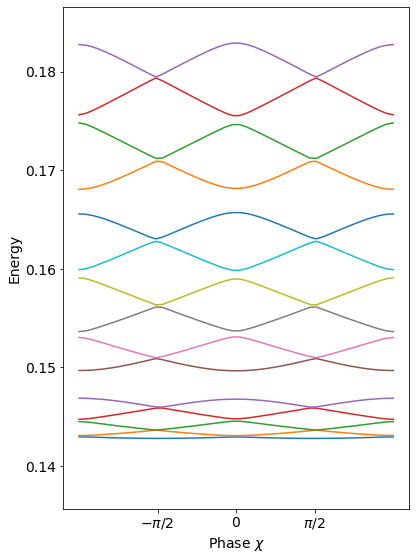

In [32]:
fig, ax = plt.subplots(figsize = (6,8))

ii = 15

ev_array = np.array(ev_list).T
[ax.plot(phases,ev) for ev in ev_array[:ii]]
ax.set_ylim([0.95*np.min(ev_array[:ii]), 1.02*np.max(ev_array[:ii])])
ax.set_xlabel("Phase $\\chi$")
ax.set_ylabel("Energy")
ax.set_xticks([-np.pi/2,0,np.pi/2])
ax.set_xticklabels(["$-\\pi/2$","$0$","$\\pi/2$"])

plt.savefig("temp_phase.pdf")

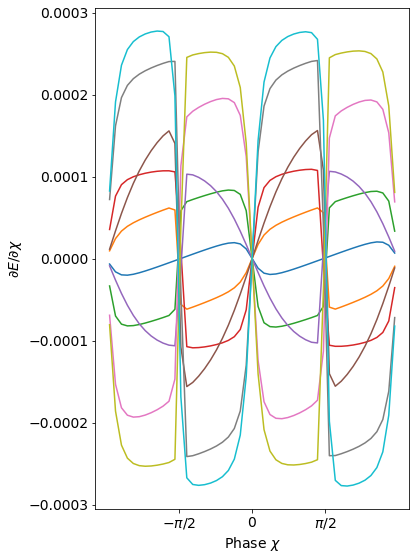

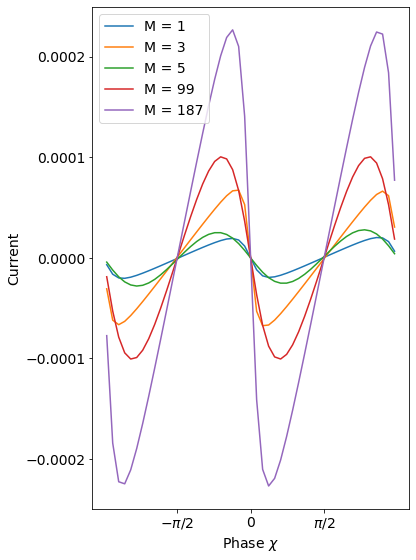

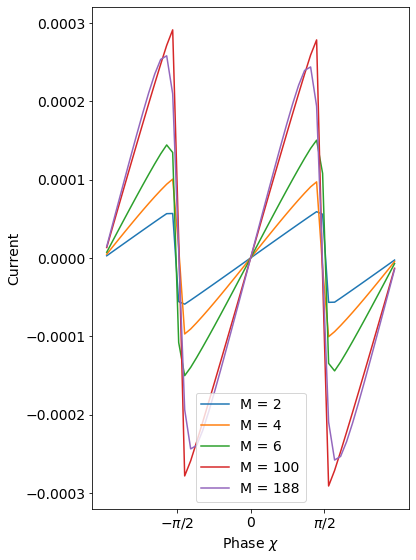

In [40]:
fig, ax = plt.subplots(figsize = (6,8))

ii = 10

ev_array = np.array(ev_list).T
[ax.plot((phases[1:] + phases[:-1])/2,np.diff(ev)) for ev in ev_array[:ii]]

ax.set_xlabel("Phase $\\chi$")
ax.set_ylabel("$\\partial E / \\partial \\chi$")
ax.set_xticks([-np.pi/2,0,np.pi/2])
ax.set_xticklabels(["$-\\pi/2$","$0$","$\\pi/2$"])

plt.savefig("temp_phase.pdf")

fig, ax = plt.subplots(figsize = (6,8))
ax.set_xlabel("Phase $\\chi$")
ax.set_ylabel("Current")
ax.set_xticks([-np.pi/2,0,np.pi/2])
ax.set_xticklabels(["$-\\pi/2$","$0$","$\\pi/2$"])

i = 0
for ii in (1,3,5,99,187):
    diff = [np.diff(ev) for ev in ev_array[:ii]]
    current = np.sum(diff,0)
    ax.plot((phases[1:] + phases[:-1])/2,current, "C"+str(i), label = "M = " + str(ii))
    i += 1
plt.legend()


fig, ax = plt.subplots(figsize = (6,8))
ax.set_xlabel("Phase $\\chi$")
ax.set_ylabel("Current")
ax.set_xticks([-np.pi/2,0,np.pi/2])
ax.set_xticklabels(["$-\\pi/2$","$0$","$\\pi/2$"])

i = 0
for ii in (2,4,6,100,188):
    diff = [np.diff(ev) for ev in ev_array[:ii]]
    current = np.sum(diff,0)
    ax.plot((phases[1:] + phases[:-1])/2,current, "C"+str(i), label = "M = " + str(ii))
    i += 1
plt.legend()



In [12]:
A = np.arange(5)

In [13]:
A

array([0, 1, 2, 3, 4])

In [19]:
np.roll(A, -1)

array([1, 2, 3, 4, 0])